In [114]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
import cv2
from shapely.ops import cascaded_union
from shapely import oriented_envelope, affinity, unary_union, Polygon, MultiPolygon
from rasterio.features import rasterize, Affine




In [2]:
countries = gpd.read_file("countries.geojson")
countries.head()

,ADMIN,ISO_A3,ISO_A2,geometry
0,Aruba,ABW,AW,"MULTIPOLYGON (((-69.99694 12.57758, -69.93639 ..."
1,Afghanistan,AFG,AF,"MULTIPOLYGON (((71.04980 38.40866, 71.05714 38..."
2,Angola,AGO,AO,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -..."
3,Anguilla,AIA,AI,"MULTIPOLYGON (((-63.03767 18.21296, -63.09952 ..."
4,Albania,ALB,AL,"MULTIPOLYGON (((19.74777 42.57890, 19.74601 42..."


In [3]:
gdf = countries.copy()

def multi_to_poly(multipoly):
    polygons = [poly for poly in multipoly.geoms]
    return gpd.GeoDataFrame(pd.DataFrame(polygons, columns=['geometry']), geometry='geometry', crs=4326)

def gdf_multi_to_poly(gdf):
    gdf_out = gpd.GeoDataFrame(pd.DataFrame([], columns=['geometry']),geometry='geometry', crs=gdf.crs)
    for i in range(gdf.shape[0]):
        if isinstance(gdf['geometry'][i], shapely.geometry.multipolygon.MultiPolygon):
            gdf_dissolve = multi_to_poly(gdf['geometry'][i])
            gdf_dissolve['admin'] = gdf['ADMIN'][i]
            gdf_out = pd.concat([gdf_out, gdf_dissolve],ignore_index=True)
        else:
            gdf_dissolve = gdf.iloc[[i]]
            gdf_dissolve['admin'] = gdf['ADMIN'][i]
            gdf_out = pd.concat([gdf_out, gdf_dissolve],ignore_index=True)
    return gdf_out

gdf_polys = gdf_multi_to_poly(gdf)

pre-translate: POLYGON ((-7792023.4539488 1411512.6079177933, -7785283.406654679 1406282.694824687, -7783978.881371946 1404858.203737876, -7782986.898583991 1402324.9143480249, -7779028.026723659 1397370.3180277166, -7778652.0698564425 1394387.7545254533, -7779906.769536971 1393279.2265838487, -7782212.336787818 1393293.14086794, -7784631.144013306 1394225.4151683983, -7786257.271082306 1395867.402413443, -7783978.881371946 1395867.402413443, -7783978.881371946 1396646.6825052095, -7787752.039593694 1398469.721342988, -7795443.303253726 1405280.4398885758, -7797717.163262687 1406217.732869746, -7798831.445316765 1406904.4813055145, -7799311.5830898 1408004.240389213, -7799085.1030291915 1409159.7278247734, -7798052.3538191905 1411108.8458281166, -7797789.636926617 1412213.4036533865, -7798224.478687527 1414069.8972582954, -7799003.570185102 1415694.4257748178, -7799166.6358732795 1416966.262678965, -7797789.636926617 1417736.8185041463, -7793160.383953277 1412417.612227836, -7792023.45

<Axes: >

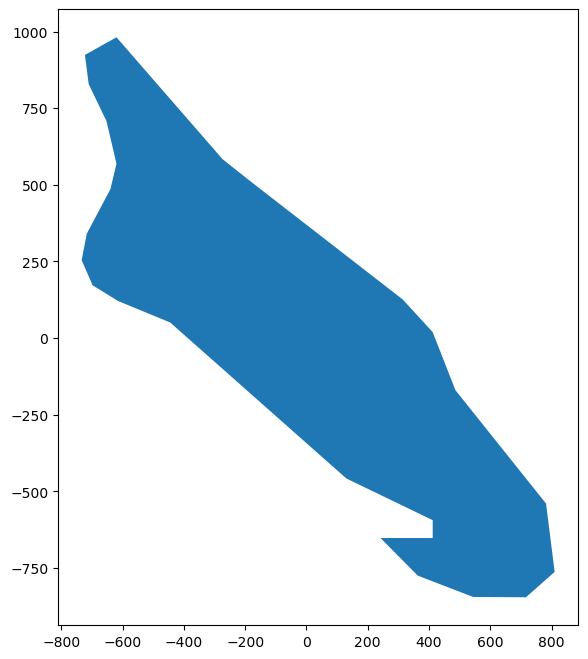

In [4]:
aruba = gdf_polys.iloc[[0]]

aruba = aruba.to_crs(3857)
area_old = aruba.area
area_new = 1000000
alpha = np.sqrt(1000000/area_old).item()


poly_a = aruba.geometry[0]
print("pre-translate:", poly_a)
poly_scale = affinity.translate(poly_a, xoff=-poly_a.centroid.x, yoff=-poly_a.centroid.y)
print("post-translate:", poly_scale)

print(f"Area pre-scale: {poly_scale.area/1000000} km^2")
poly_scale = affinity.scale(poly_scale, xfact=alpha, yfact=alpha, origin=(poly_scale.centroid.x, poly_scale.centroid.y))
#poly_scale = poly_scale.apply(lambda row: affinity.scale(row.geometry, xfact=alpha, yfact=alpha, origin=(row.geometry.centroid.x, row.geometry.centroid.y)), axis=1)
print(f"Area post-scale: {poly_scale.area/1000000} km^2")


fig, ax = plt.subplots(figsize=(10,8))

gpd.GeoSeries(poly_scale).plot(ax=ax)


<Axes: >

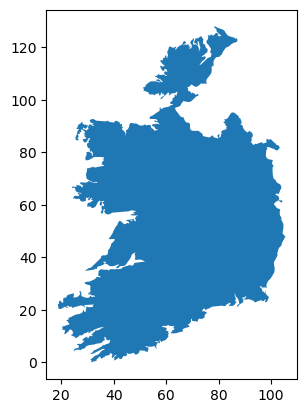

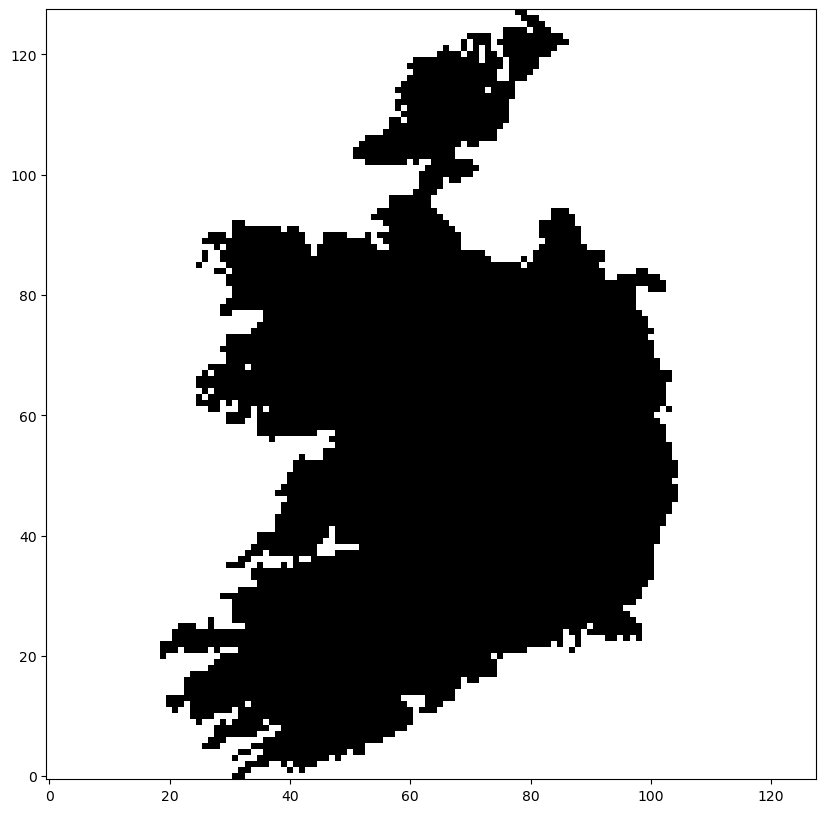

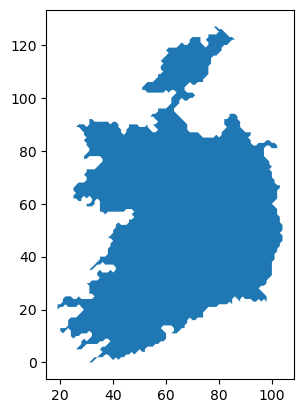

In [118]:
gdf_polys_scaled = gdf_polys.copy().to_crs(3857)

window_size = 128

gdf_polys_scaled['area_old'] = gdf_polys_scaled.geometry.area
gdf_polys_scaled['ratio'] = gdf_polys_scaled.geometry.apply(lambda row: (row.bounds[2]-row.bounds[0])/(row.bounds[3]-row.bounds[1]))
gdf_polys_scaled['width'] = gdf_polys_scaled.geometry.apply(lambda row: row.bounds[2]-row.bounds[0])
gdf_polys_scaled['height'] = gdf_polys_scaled.geometry.apply(lambda row: row.bounds[3]-row.bounds[1])

gdf_polys_scaled.geometry = gdf_polys_scaled.apply(lambda row: affinity.translate(row.geometry, xoff=-row.geometry.centroid.x, yoff=-row.geometry.centroid.y), axis=1)

# Scale to fit in a given square window
gdf_polys_scaled.geometry = gdf_polys_scaled.apply(lambda row: affinity.scale(row.geometry, xfact=window_size/row.width if row.ratio > 1 else window_size/row.height , yfact=window_size/row.height if row.ratio < 1 else window_size/row.width, origin=(row.geometry.centroid.x, row.geometry.centroid.y)), axis=1)

# Scale to a paritcular area
#gdf_polys_scaled.geometry = gdf_polys_scaled.apply(lambda row: affinity.scale(row.geometry, xfact=np.sqrt(2000/row.area_old).item(), yfact=np.sqrt(2000/row.area_old).item(), origin=(row.geometry.centroid.x, row.geometry.centroid.y)), axis=1)

# put it in the positive axes
gdf_polys_scaled.geometry = gdf_polys_scaled.apply(lambda row: affinity.translate(row.geometry, xoff=-row.geometry.bounds[0] , yoff=-row.geometry.bounds[1]), axis=1)
gdf_polys_scaled.geometry = gdf_polys_scaled.apply(lambda row: affinity.translate(row.geometry, xoff=window_size/2 - row.geometry.centroid.x if row.ratio < 1 else 0, yoff=window_size/2 - row.geometry.centroid.y if row.ratio > 1 else 0), axis=1)

gdf_polys_scaled['area_new'] = gdf_polys_scaled.geometry.area


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
pre-save (128, 128)
loaded image (128, 128)


<Axes: >

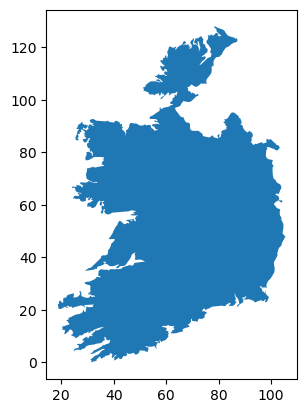

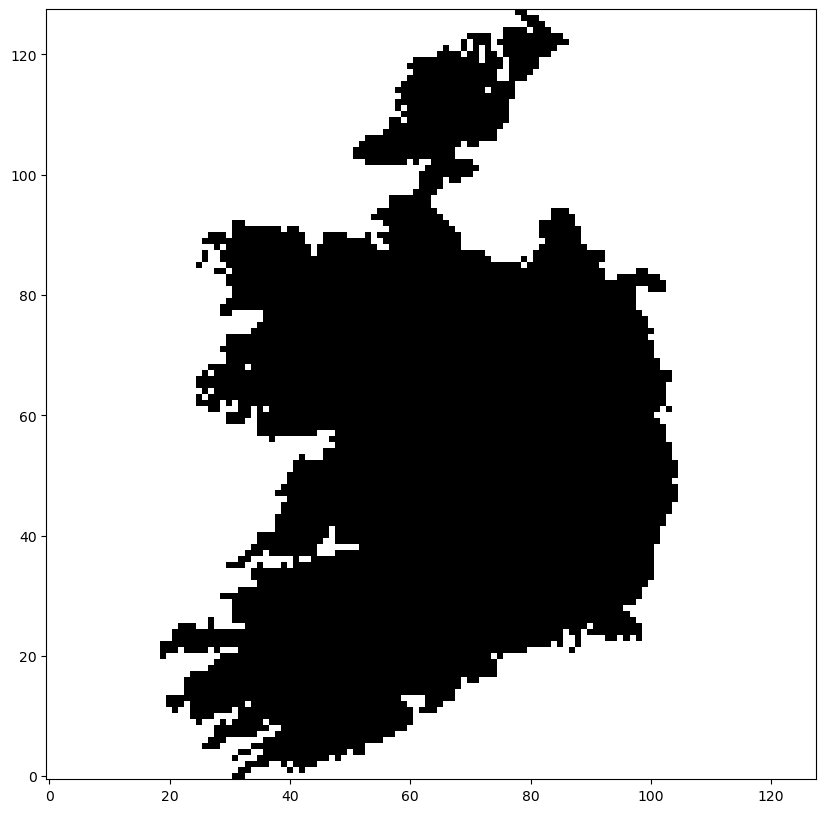

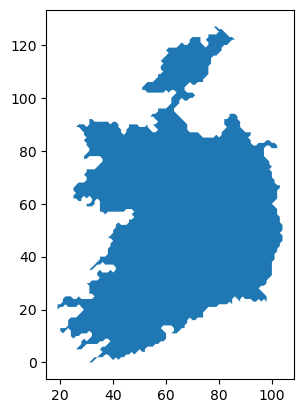

In [135]:
ire = gdf_polys_scaled.iloc[[2145]]


ire.plot()

# Rasterize vector using the shape and coordinate system of the raster
rasterized = rasterize(ire.geometry, out_shape = (window_size,window_size))

print(rasterized)

# Plot raster
fig, ax = plt.subplots(1, figsize = (10, 10))

plt.imshow(rasterized, cmap='Greys', origin='lower')
plt.savefig('blkwht.png')


cv2.imwrite("ire.png", cv2.flip(rasterized*255, 0))

ire_read = cv2.imread("ire.png", cv2.IMREAD_GRAYSCALE)

print("pre-save", rasterized.shape)

print("loaded image", ire_read.shape)

contours, _ = cv2.findContours(cv2.flip(ire_read,0), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
polygons = [np.array(polygon).squeeze() for polygon in contours]

raster_to_poly = MultiPolygon([Polygon(poly) for poly in polygons])

gpd.GeoSeries(raster_to_poly).plot()

In [160]:
import os 
from pathlib import Path
cdir = os.getcwd() 
os.makedirs(Path(os.path.dirname(cdir),"country_rasters"),  exist_ok=True)

rasters = [rasterize(gpd.GeoSeries(poly), out_shape=(window_size, window_size)) for poly in gdf_polys_scaled.geometry]

for i, raster in enumerate(rasters):
    cv2.imwrite(str(Path(os.path.dirname(cdir),f"country_rasters/{i}.png")), cv2.flip(raster*255, 0))